In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

import findspark
import pyspark

from matplotlib.pyplot import cm
from sklearn.cluster import KMeans
import sklearn.cluster
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

# 2. Grouping customers together!

## 2.1 Getting your data and feature engineering

In [5]:
data = pd.read_csv('bank_transactions.csv')

Some basic data cleaning.

In [7]:
data = data.dropna()
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)

In [8]:
def convert_time(value):
    sec = value % 100
    minutes = (value//100)%100
    hours = (value//10000)%100
    date = str(hours)+":"+str(minutes)+":"+str(sec)
    datetime_object = datetime.strptime(date,'%H:%M:%S').time()
    return datetime_object

In [9]:
data.TransactionTime = data.TransactionTime.apply(lambda x: convert_time(int(x)))

In [10]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

In [11]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5


In [12]:
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 75.2+ MB


In [13]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

To convert indian rupies in usd

In [14]:
data['CustAccountBalance'] = data['CustAccountBalance'].apply(lambda x: x*0.012)
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].apply(lambda x: x*0.012)

In [70]:
data.to_csv('cleaned_data.csv',index=False)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 75.2+ MB


Now we need to build a customer-view of the data. 

##### a) Number of transactions

In [15]:
num_transactions = data\
                   .groupby('CustomerID',as_index=False)\
                   .count()[['CustomerID','TransactionID']]\
                   .rename(columns={'TransactionID':'Number of transactions'})

##### b) Number of transactions with a balance bigger than 100 USD

In [16]:
high_transactions = data[data['CustAccountBalance'] > 100]\
                    .groupby('CustomerID', as_index=False)\
                    .count()[['CustomerID','TransactionID']]\
                    .rename(columns={'TransactionID':'Number of high volume transactions'})

##### c) Average amount of the transactions

In [17]:
average_transactions = data\
                       .groupby('CustomerID', as_index=False)\
                       .mean()[['CustomerID','TransactionAmount (INR)']]\
                       .rename(columns={'TransactionAmount (INR)':'AVG Transaction'})

##### d) Average balance

In [18]:
average_balance = data\
                  .groupby('CustomerID', as_index = False)\
                  .mean()[['CustomerID','CustAccountBalance']]\
                  .rename(columns={'CustAccountBalance':'AVG Balance'})

##### e) Average difference between the balance and the transaction amount for each customer 

In [19]:
data['Utilization'] = data['CustAccountBalance'] - data['TransactionAmount (INR)']

In [20]:
average_utilization = data\
                      .groupby('CustomerID', as_index = False)\
                      .mean()[['CustomerID','Utilization']]\
                      .rename(columns={'Utilization':'AVG Utilization'})

##### f) Most common gender of the customer

In [22]:
most_common_gender = data\
                     .groupby('CustomerID', as_index=False)['CustGender']\
                     .apply(lambda x: x.mode().iat[0])\
                     .rename(columns={'CustGender':'Most common gender'})

##### h) Most frequent location of the customer



In [23]:
most_common_location = data\
                       .groupby('CustomerID', as_index=False)['CustLocation']\
                       .apply(lambda x: x.mode().iat[0])\
                       .rename(columns={'CustLocation':'Most frequent location'})

Now we can concatenate our datasets to build a customer view of our transaction-data. 

In [24]:
customer_view = num_transactions\
                .merge(high_transactions, how='left')\
                .merge(average_transactions)\
                .merge(average_balance)\
                .merge(average_utilization)\
                .merge(most_common_gender)\
                .merge(most_common_location)

In [25]:
customer_view.fillna(0,inplace=True)

In [26]:
customer_view.to_csv('customer_view.csv', index=False)

In [82]:
customer_view = pd.read_csv('customer_view.csv')

In [27]:
customer_view

,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location
0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI
1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI
2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI
3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN
4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA
...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI
839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE
839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR
839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI


#### ***Feature engineering: 20 new features***

The feature we defined are the following ones:
1) Customer age, leveraging one of the recorded dates of birthday
2) The transaction with the highest volume
3) The transaction with the lowest volume
4) The number of transactions recorded in New Delhi, 
5) The number of transactions recorded in Mumbai 
6) The number of transactions recorded in Bangalore
7) The day of the week in which each costumer made the most of his transactions
8) The month in which each costumer made the most of his transactions
9) The highest recorded value of his balance
10) The lowest recorded value of his balance
11) The number of transactions made when the balance was higher than its average
12) The highest recorded utilization
13) The lowest recorded utilization
14) The date of the last recorded transaction
15) The date of the first recorded transaction
16) The mean time between two transactions
17) The ration between the last recorded value for balance and the first recorded value for balance
18) The number of transactions higher than 1000 USD
19) The hour of the day when the customer made the most of his transactions
20) For each customer, the percentage of transactions made by female over the whole volume of transactions

Customer Age

In [28]:
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)

customer_view = customer_view.merge(data[['CustomerID','CustomerAge']], how='left')

customer_view = customer_view.drop_duplicates(subset=['CustomerID'])

Max transactions ever done

In [29]:
max_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                    .groupby('CustomerID', as_index=False)\
                    .max()\
                    .rename(columns={'TransactionAmount (INR)':'MAX Transaction'})
                    
customer_view = customer_view.merge(max_transactions)

Min transaction


In [30]:
min_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                    .groupby('CustomerID', as_index=False)\
                    .min()\
                    .rename(columns={'TransactionAmount (INR)':'MIN Transaction'})
                    
customer_view = customer_view.merge(min_transactions)

Number of visits in New Delhi 

In [31]:
visits_new_delhi = data[data.CustLocation == 'NEW DELHI'][['CustomerID','CustLocation']]\
                   .groupby('CustomerID', as_index=False)\
                   .count()\
                   .rename(columns={'CustLocation':'Number of visits in New Delhi'})
                   
customer_view = customer_view.merge(visits_new_delhi, how='left')


Number of visits in Mumbai

In [32]:
visits_mumbai = data[data.CustLocation == 'MUMBAI'][['CustomerID','CustLocation']]\
                .groupby('CustomerID', as_index=False)\
                .count()\
                .rename(columns={'CustLocation':'Number of visits in Mumbai'})
                
customer_view = customer_view.merge(visits_mumbai, how='left')

Number of visits in Bangalore. 

In [33]:
visits_bangalore = data[data.CustLocation == 'BANGALORE'][['CustomerID','CustLocation']]\
                    .groupby('CustomerID', as_index=False)\
                    .count()\
                    .rename(columns={'CustLocation':'Number of visits in Bangalore'})

customer_view = customer_view.merge(visits_bangalore, how='left')

Day of the week in which he does the most of transactions. 

In [34]:
data['Day of the week'] = data.TransactionDate.dt.dayofweek

favourite_day = data\
                .groupby('CustomerID', as_index = False)['Day of the week']\
                .apply(lambda x: x.mode().iat[0])\
                .rename(columns={'Day of the week':'Favourite day of the week'})
                
customer_view = customer_view.merge(favourite_day)

Max balance

In [35]:
max_balance = data[['CustomerID','CustAccountBalance']]\
                .groupby('CustomerID', as_index = False)\
                    .max()\
                        .rename(columns={'CustAccountBalance':'Max Balance'})
                        
customer_view = customer_view.merge(max_balance)

Min balance

In [36]:
min_balance = data[['CustomerID','CustAccountBalance']]\
                .groupby('CustomerID', as_index = False)\
                    .min()\
                        .rename(columns={'CustAccountBalance':'Min Balance'})
                        
customer_view = customer_view.merge(min_balance)

Month with the most recorded transactions

In [37]:
data['Month'] = data.TransactionDate.dt.month

favourite_month = data\
                .groupby('CustomerID', as_index = False)['Month']\
                .apply(lambda x: x.mode().iat[0])\
                .rename(columns={'Month':'Favourite Month'})
                
customer_view = customer_view.merge(favourite_month)

Number of transactions when balance was over the mean balance.

In [38]:
data = data.merge(customer_view[['CustomerID','AVG Balance']], how='left')

useful_view = data[data.CustAccountBalance > data['AVG Balance']]

filtered_mean_balance_transactions = useful_view[['CustomerID','TransactionID']]\
                                        .groupby('CustomerID', as_index=0)\
                                            .count()\
                                                .rename(columns={'TransactionID':'Transaction when balance higher than the AVG'})
                                                
customer_view = customer_view.merge(filtered_mean_balance_transactions, how ='left')

Max utilization

In [39]:
max_utilization = data[['CustomerID','Utilization']]\
                .groupby('CustomerID', as_index = False)\
                    .max()\
                        .rename(columns={'Utilization':'Max Utilization'})
                        
customer_view = customer_view.merge(max_utilization)

Min utilization

In [40]:
min_utilization = data[['CustomerID','Utilization']]\
                .groupby('CustomerID', as_index = False)\
                    .min()\
                        .rename(columns={'Utilization':'Min Utilization'})
                        
customer_view = customer_view.merge(min_utilization)

Last transaction

In [41]:
last_transactions = data[['CustomerID','TransactionDate']]\
                                    .groupby('CustomerID', as_index=False)\
                                        .max()\
                                            .rename(columns={'TransactionDate':'Last transaction'})
                                            
customer_view = customer_view.merge(last_transactions)

First transaction

In [42]:
first_transactions = data[['CustomerID','TransactionDate']]\
                                    .groupby('CustomerID', as_index=False)\
                                        .min()\
                                            .rename(columns={'TransactionDate':'First transaction'})
                                            
customer_view = customer_view.merge(first_transactions)

Mean time between transactions

In [43]:
mean_time_between_transactions = (customer_view['Last transaction']-customer_view['First transaction'])/(customer_view['Number of transactions']-1)

customer_view['Mean time between transactions'] = mean_time_between_transactions

Ratio between final recorded balance and first recorded balance

In [44]:
first_recorded_balance = data[['CustomerID','CustAccountBalance','TransactionDate']].sort_values(by='TransactionDate')\
                         .groupby('CustomerID', as_index=False)\
                         .min()\
                         .rename(columns={'CustAccountBalance':'First balance'})

last_recorded_balance = data[['CustomerID','CustAccountBalance','TransactionDate']].sort_values(by='TransactionDate')\
                         .groupby('CustomerID', as_index=False)\
                         .max()\
                         .rename(columns={'CustAccountBalance':'Last balance'})

customer_view['Balance traction'] = (last_recorded_balance['Last balance'] - first_recorded_balance['First balance'])/first_recorded_balance['First balance']

Number of transactions higher than 1000 USD. 

In [45]:
highest_transactions = data[data['CustAccountBalance'] > 1000]\
                       .groupby('CustomerID', as_index=False)\
                       .count()[['CustomerID','TransactionID']]\
                       .rename(columns={'TransactionID':'Number of higher volume transactions'})
                       
customer_view = customer_view.merge(highest_transactions, how='left')

Favourite hour

In [47]:
hour = []
for idx in list(data.index.values):
    hour.append(data.TransactionTime[idx].hour)

data['Hour'] = hour

favourite_hour = data\
                 .groupby('CustomerID',as_index=False)['Hour']\
                 .apply(lambda x: x.mode().iat[0])\
                 .rename(columns={'Hour':'Favourite Hour'})
                 
customer_view = customer_view.merge(favourite_hour)

Percentage of female outgo

In [46]:
female_outgo = data[data['CustGender'] == 'F'][['CustomerID','TransactionAmount (INR)']]\
                             .groupby('CustomerID', as_index=False)\
                             .sum()\
                             .rename(columns={'TransactionAmount (INR)':'Female outgo'})

total_transactions = data[['CustomerID','TransactionAmount (INR)']]\
                     .groupby('CustomerID', as_index=False)\
                     .sum()\
                     .rename(columns={'TransactionAmount (INR)':'Total transaction'})
            
customer_view['Female outgo'] = female_outgo['Female outgo']/total_transactions['Total transaction']

In [48]:
customer_view

,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,MAX Transaction,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,57.000,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days,2.697780,1.0,0.930278,1
1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,17.988,...,NaN,272.46588,272.46588,2016-08-14,2016-08-14,NaT,0.000000,NaN,0.803869,20
2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,14.460,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days,3.217322,1.0,0.020619,15
3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,0.360,...,NaN,5.59416,5.59416,2016-09-15,2016-09-15,NaT,0.000000,NaN,18.566667,17
4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,60.000,...,NaN,984.70380,984.70380,2016-08-18,2016-08-18,NaT,0.000000,1.0,0.020000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI,32,8.292,...,NaN,1588.51476,1588.51476,2016-07-08,2016-07-08,NaT,0.000000,1.0,NaN,0
839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE,26,2.664,...,NaN,1150.09752,1150.09752,2016-09-15,2016-09-15,NaT,0.000000,1.0,NaN,12
839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR,29,1.512,...,NaN,65.20500,65.20500,2016-08-18,2016-08-18,NaT,0.000000,NaN,NaN,12
839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI,28,0.600,...,NaN,422.95104,422.95104,2016-08-28,2016-08-28,NaT,0.000000,NaN,NaN,21


In [49]:
customer_view.to_csv('customer_engineered.csv')

*Some quick data cleaning...*

In [2]:
customer_view = pd.read_csv('customer_engineered.csv')

In [4]:
customer_view['Mean time between transactions'].fillna(pd.Timedelta('0 days'), inplace=True)

In [5]:
customer_view.fillna(0,inplace=True)


In [6]:
customer_view.isna().sum()

Unnamed: 0                                      0
CustomerID                                      0
Number of transactions                          0
Number of high volume transactions              0
AVG Transaction                                 0
AVG Balance                                     0
AVG Utilization                                 0
Most common gender                              0
Most frequent location                          0
CustomerAge                                     0
MAX Transaction                                 0
MIN Transaction                                 0
Number of visits in New Delhi                   0
Number of visits in Mumbai                      0
Number of visits in Bangalore                   0
Favourite day of the week                       0
Max Balance                                     0
Min Balance                                     0
Favourite Month                                 0
Transaction when balance higher than the AVG    0


In [7]:
customer_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    839081 non-null  int64  
 1   CustomerID                                    839081 non-null  object 
 2   Number of transactions                        839081 non-null  int64  
 3   Number of high volume transactions            839081 non-null  float64
 4   AVG Transaction                               839081 non-null  float64
 5   AVG Balance                                   839081 non-null  float64
 6   AVG Utilization                               839081 non-null  float64
 7   Most common gender                            839081 non-null  object 
 8   Most frequent location                        839081 non-null  object 
 9   CustomerAge                                   83

In [8]:
customer_view.head()

,Unnamed: 0,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days 00:00:00,2.697780,1.0,0.930278,1
1,1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,...,0.0,272.46588,272.46588,2016-08-14,2016-08-14,0 days 00:00:00,0.000000,0.0,0.803869,20
2,2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days 00:00:00,3.217322,1.0,0.020619,15
3,3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,...,0.0,5.59416,5.59416,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,0.0,18.566667,17
4,4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,...,0.0,984.70380,984.70380,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,1.0,0.020000,14


## 2.2 Choose your features (variables)!

*We decided for the Principal Component Analysis because it is the most common dimensionality-reduction procedure and a from-scratch implementation could have been a great chance to better understand how it works inner. Further consideration are to be found later.*

In order to apply principal component analysis we have to consider only the numeric features, so we are dropping some columns from the dataset. 

In [3]:
customer_view = pd.read_csv('customer_engineered.csv')

In [9]:
customer_view

,Unnamed: 0,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,...,Transaction when balance higher than the AVG,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Female outgo,Favourite Hour
0,0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,...,1.0,1437.89448,333.00876,2016-09-26,2016-09-08,18 days 00:00:00,2.697780,1.0,0.930278,1
1,1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,...,0.0,272.46588,272.46588,2016-08-14,2016-08-14,0 days 00:00:00,0.000000,0.0,0.803869,20
2,2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,...,1.0,1939.18512,446.06568,2016-07-08,2016-01-08,182 days 00:00:00,3.217322,1.0,0.020619,15
3,3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,...,0.0,5.59416,5.59416,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,0.0,18.566667,17
4,4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,...,0.0,984.70380,984.70380,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,1.0,0.020000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI,32,...,0.0,1588.51476,1588.51476,2016-07-08,2016-07-08,0 days 00:00:00,0.000000,1.0,0.000000,0
839077,839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE,26,...,0.0,1150.09752,1150.09752,2016-09-15,2016-09-15,0 days 00:00:00,0.000000,1.0,0.000000,12
839078,839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR,29,...,0.0,65.20500,65.20500,2016-08-18,2016-08-18,0 days 00:00:00,0.000000,0.0,0.000000,12
839079,839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI,28,...,0.0,422.95104,422.95104,2016-08-28,2016-08-28,0 days 00:00:00,0.000000,0.0,0.000000,21


In [28]:
new_customer_view['Mean time between transactions'].fillna('0 days 00:00:00', inplace=True)

In [10]:
new_customer_view = customer_view.drop(columns=['Most common gender', 'Most frequent location', 'Last transaction', 'First transaction'])

In [17]:
new_customer_view['Mean time between transactions'] = new_customer_view['Mean time between transactions'].apply(lambda x: int(str(x)[:-14]))

In [18]:
new_customer_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 25 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    839081 non-null  int64  
 1   CustomerID                                    839081 non-null  object 
 2   Number of transactions                        839081 non-null  int64  
 3   Number of high volume transactions            839081 non-null  float64
 4   AVG Transaction                               839081 non-null  float64
 5   AVG Balance                                   839081 non-null  float64
 6   AVG Utilization                               839081 non-null  float64
 7   CustomerAge                                   839081 non-null  int64  
 8   MAX Transaction                               839081 non-null  float64
 9   MIN Transaction                               83

In [19]:
new_customer_view.isna().sum()
new_customer_view.replace([np.inf, -np.inf], 0, inplace=True)

Now we want to set the CustomerID as the index set for our dataframe.

In [20]:
new_customer_view = new_customer_view.set_index('CustomerID')
new_customer_view = new_customer_view.drop(columns=['Unnamed: 0'])

Now we have only numerical features, so we can apply PCA. In order to do this, we define our PCA class with the following methods:
- $init$ is the builder of the class; its parameter is the dimension we are retrieving from the process;
- $standardize$ is a method that takes the data of interest and standardize them: in other words it center each column in its mean value and then divide each data point by the variance of the column. This is important for many reasons, such as getting uniform values with respect to different measure unities and preventing higher scales to prevale;
- $decomposition$ uses the covariance matrix method to compute the projection matrix of the PCA, using linalg module of numpy to get its eigen-decomposition;
- $projection$ performs the projection of the data with respect to the principal components.

In [139]:
class PCA:
    def __init__(self, dimension):
        '''
        Class builder, gets class parameters
        '''
        self.dimension = dimension

    def standardize(self, data):
        '''
        Centers each data column in its mean value and then divide each data point by the variance of the column, in order to get 
        mean equal to 0 and standard deviation equal to 1
        '''
        data = data.copy()
        for column in data.columns:
            data[column] = (data[column]-data[column].mean())/data[column].std()
        return data.to_numpy()
            
    def decomposition(self,data):
        '''
        First it computes the covariance matrix of the standardized data column-wise; then it calls numpy.linalg.eigh to get an hortogonal 
        eigen-decomposition of it. Then we group the eigenvectors with respect to linked eigenvalue and we sort them in descending order. 
        This last step is needed to retrieve a certain amount of variance, which is directly linked to the eigenvalue. 
        The proj_matrix is the the matrix we get from retrieving a sub-matrix of the eigen-vactors one considering only the number of principal 
        components corresponding to self.dimension. variance_ratio and cumulative_variance_ratio are very important to set thresholds over the 
        choosen number of principal components.
        '''
        stand = self.standardize(data)
        cov_matrix = np.cov(stand, rowvar=False)
        self.eig_vals, self.eig_vecs = np.linalg.eigh(cov_matrix)
        
        self.eigen = [(self.eig_vals[i], self.eig_vecs[i,:]) for i in range(len(self.eig_vals))]
        self.eigen.sort(key = lambda tup: tup[0], reverse=True)

        self.eig_vals_sorted = np.array([pair[0] for pair in self.eigen])
        self.eig_vecs_sorted = np.array([pair[1] for pair in self.eigen])
        
        self.proj_matrix = self.eig_vecs_sorted[:self.dimension,:]
        self.variance_ratio = [i/np.sum(self.eig_vals) for i in self.eig_vals_sorted[:self.dimension]]
        self.cumulative_variance_ratio = np.cumsum(self.variance_ratio)

        return self

    def projection(self, data):
        '''
        Finally this method performs the actual projection of the data along the directions of the principal components.
        '''
        stand = self.standardize(data)
        proj = stand.dot(self.proj_matrix.T)
        
        return proj    

In [131]:
new = new_customer_view

In [132]:
#We are computing and plotting the cumulative variance ratio for different number of principal components in order to find
#The minimum dimension that guarantees the 70% of total variance.

cumulative_variance = {}
for i in range(1,23):
    projection_matrix = PCA(dimension=i).decomposition(new)
    cumulative_variance[i] = projection_matrix.cumulative_variance_ratio[i-1]

Text(0.5, 1.0, 'Cumulative variance with respect to k components')

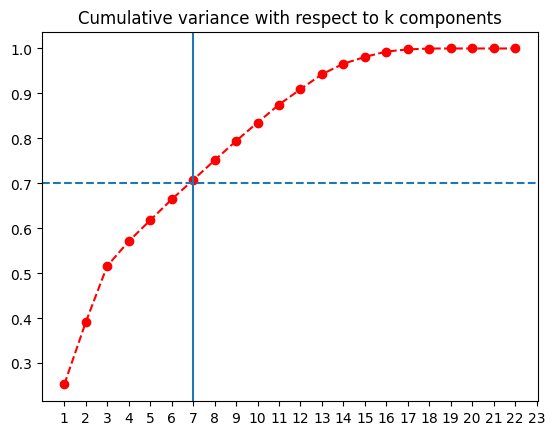

In [133]:
#Plotting script of the cumulative variance

xs = list(cumulative_variance.keys())
ys = list(cumulative_variance.values())

plt.plot(xs,ys,'ro', linestyle='dashed')
plt.axhline(y=0.7, linestyle = 'dashed')
plt.axvline(x = 7)
plt.xticks([i for i in range(1,24)])
plt.title('Cumulative variance with respect to k components')

In [154]:
#Now that we have find a good number of principal components, we perform the Principal Component Analysis

newPCA = PCA(dimension=7).decomposition(new)
projected = newPCA.projection(new)

In [156]:
#Converting the projected data into a pandas dataframe...

projected_data = pd.DataFrame(projected)

In [161]:
#...and visualizing it

projected_data

,0,1,2,3,4,5,6
0,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
1,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
2,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
3,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
4,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
839076,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
839077,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
839078,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358
839079,0.240675,0.436996,0.744229,0.069321,-0.130518,-0.492380,-0.907483


In [159]:
customer_view['CustomerID']

0         C1010011
1         C1010012
2         C1010014
3         C1010018
4         C1010024
            ...   
839076    C9099836
839077    C9099877
839078    C9099919
839079    C9099941
839080    C9099956
Name: CustomerID, Length: 839081, dtype: object

In [163]:
#We want the CustomerID to still be the primary key for our projected data 
#Because it can be crucial in cluster phase

projected_data.index = customer_view['CustomerID']

In [164]:
projected_data

,0,1,2,3,4,5,6
CustomerID,,,,,,,
C1010011,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
C1010012,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
C1010014,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
C1010018,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
C1010024,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
C9099836,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
C9099877,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
C9099919,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358


Saving our projected data.

In [167]:
projected_data.to_csv('projected_data.csv')

This little scripts makes it always ready to be used and with the right format. 

In [13]:
loaded_data = pd.read_csv('projected_data.csv')
loaded_data.index = loaded_data.CustomerID
loaded_data = loaded_data.drop(columns=['CustomerID'])

In [3]:
loaded_data

,0,1,2,3,4,5,6
CustomerID,,,,,,,
C1010011,0.369013,-2.160284,-0.396444,0.759492,2.942567,0.357512,-0.194744
C1010012,0.080190,0.447543,-0.924502,0.126733,-0.955291,-0.568717,-0.640784
C1010014,-1.470811,-2.227947,-3.248590,-0.031737,-1.770162,-0.540259,-1.218541
C1010018,0.624201,0.451522,0.184744,0.227863,-0.048653,0.590936,0.287719
C1010024,0.206114,0.423709,0.104382,0.027240,0.001221,-0.773578,0.525623
...,...,...,...,...,...,...,...
C9099836,-0.116621,0.402400,0.638994,-0.132437,0.117945,1.109873,0.931946
C9099877,-0.282546,0.422177,1.404765,0.131523,-0.365208,0.254408,-0.110340
C9099919,0.399745,0.443395,0.265595,0.108236,-0.049302,0.962295,0.695358


# 2.3 Cluster!

Let's assume that we have a set of points :\
 $\{\overrightarrow{x_{1}},\cdot\cdot\cdot,\overrightarrow{x_{n}}\}$, with $\overrightarrow{x_{i}}\in \R^d$ and fixed $k\in N$,$k>0$.

Our goal is to find a partitioning $C = { {C_{1}, \cdot \cdot \cdot ,C_{k}} }$ and representatives $\{\overrightarrow{c_{1}},\cdot\cdot\cdot,\overrightarrow{c_{k}}\}$ ,  s.t. $$min \sum_{j = 1}^{K} \sum_{x \in C_{j}} ||x-c_{j}||^2$$ 
where:
* $||x-c_{j}||^2 = \sum_{e=1}^{d}(x_e - (c_j)_l)^2$
* $\sum_{x \in C_{j}}^{K} ||x-c_{j}||^2$ is the so called _Within Sum of Squares_ and it is a measure of how well a centroid represents the members of its cluster;
* the objective function of the optimization problem is a sort of cost function dependent on the performance of the generated centroids. 

Implementation:
* Choose the number of clusters k
* Select k random points from the data as centroids(representatives)
* Assign all the points to the closest cluster centroid
* Recompute the centroids of newly formed clusters
* Repeat steps 3 and 4

There are essentially three stopping criteria that can be adopted to stop the K-means algorithm:

* Centroids of newly formed clusters do not change
* Points remain in the same cluster
* Maximum number of iterations are reached

We need to setup a PySpark environment to perform a MapReduce pipeline. 

In [4]:
import findspark
findspark.init()
import pyspark

import logging
s_logger = logging.getLogger('py4j.java_gateway')
s_logger.setLevel(logging.ERROR)
sc = pyspark.SparkContext(appName='Cluster')  

We are loading the file we made from the PCA procedure over the engineered customer view.

In [5]:
data = sc.textFile('projected_data.csv')

Then we are doing a little bit of preprocessing: we are removing the first line because it contains the name of the columns with $filter$ function, and then we are defining a subroutine to actually have the data in a useful format. 

In [6]:
#header is the row that contains information about the column names
#We don't need it in our MapReduce implementation

header = data.first()
data = data.filter(lambda row: row != header)

In [7]:
#The function 'formatting' its fundamental to do the second step of the preprocessing
#It basically gets a row in a string format like 'CustomerID,feature_0_value,feature_1_value,...'
#and converts it in a tuple key-value like        (CustomerID, np.ndarray)

def formatting(row):
    splitted = row.split(',')
    stripped = list(map(lambda spl: spl.strip(), splitted))
    return (stripped[0], np.array(list(map(float, stripped[1:]))))

data = data.map(lambda row: formatting(row))

This is just to ensure that we have made a correct formatting: we want the $CustomerID$ as a key, to which we associate a $numpy.ndarray$ that contains numeric values for the feature we defined through the PCA.

In [8]:
data.first()

('C1010011',
 array([ 0.36901321, -2.1602838 , -0.3964439 ,  0.75949164,  2.9425666 ,
         0.35751245, -0.19474423]))

Now we are defining a class for the actual cluster. The methods are here described:
- $init$ is just the class-builder: the parameters of this class are $dim$ the dimension of the data-samples, the number of cluster $k$, the tolerance $\epsilon$ to declare convergence, the number of $max_run$ and a $seed$ for results reproduction;
- $euclidean\ distance$ is a method that leverages $linalg$ module of Numpy to define the euclidean distance as the norm of a difference; 
- $k\ means\ initialization$ initializes randomly $k$ centroids whose dimension is $dim$;
- $find\ centroid$ assigns to each data point its cluster through computing its closest centroid;
- $loss\ function$ is the cost of the procedure, defined as $\sum_{j=1}^{k} || \mu^t_j - \mu^{t-1}_j ||^2$, where $\mu$ is the centroids-vector;
- $fit$ finds the best cluster for given data: it uses a MapReduce pipeline to find and update the best centroid for the given data;
- $predict$ assign to each data point its cluster after the $fit$ operation: also this is a MapReduce pipeline;
- $dispersion$ is a method that we are going to use to define the elbow method;
- $silhouette$ is another metric for optimization with respect to parameter $k$. 

In [39]:
class Cluster:
    '''
    Class builder 
    '''
    def __init__(self, dim, k=2, epsilon=0.001, max_run=10, seed=None):
        self.k = k
        self.dim = dim
        self.epsilon = epsilon
        self.max_run = max_run
        self.seed = seed

    def euclidean_distance(self, a,b):
        '''
        This method is simply the euclidean distance computed as the norm of a difference using numpy linal module
        '''
        a = np.array(a)
        b = np.array(b)
        return np.linalg.norm(a-b)

    def k_means_initialization(self, seed):
        '''
        Random initialization for the k_means algorithm of k centroids of dim #components
        '''
        np.random.seed(seed)
        return np.random.rand(self.k, self.dim)

    def find_centroid(self, x: np.ndarray, centroids: np.ndarray):
        '''
        We are leveraging numpy broadcasting to find the belonging partition of a point as the index that points its nearest centroid 
        '''
        return np.argmin(x-centroids)
    
    def loss_function(self, centroids_t, centroids_t_1):
        '''
        The loss function is computed between two vectors of centroid gathered from two following iterations of the algorithm
        '''
        return sum([np.power(self.euclidean_distance(centroids_t[i], centroids_t_1[i]), 2) 
                   for i in range(len(centroids_t))])
    
    def fit(self, data):
        '''
        This is the actual core of the class and consists of different steps:
        -We initialize two variables to store both the centroids and to store the previous ones, in order to take 
        track of the loss function
        -We also initialize a counter to set a stop condition over the algorithm with respect to self.max_run
        -Then there's the MapReduce pipeline that is made itself of different steps:
            1) Mapping step to map each tuple ('CustomerID', CustomerArray) to (CustomerArray, NearestCentroid)
            2) Mapping step to map each tuple (CustomerArray, NearestCentroid) to (NearestCentroid, CustomerArray): basically we are reverting 
            key and value in order to make it easier to perform the reduction when computing the new centroids
            3) AggregateByKey step which basically accumulate in an initialized tuple both the sum of the assigned data points and a counter of 
            the number of the assigned data points: we are getting tuples like (NearestCentrois, SumOfValues, LengthOfPartition)
            4) Mapping step to compute the average
            5) Collecting step to get an array of centroids
        -We store the output of the previous procedure in a temporary variable to correctly set the new centroids and switch the previous ones 
        in their dedicated variable
        -When we are under the tolerance we setted up to declare of convergence, or we reached the max number of iterations, we exit the while-loop
        and get the centroids and a record of the loss.
        '''
        centros = self.k_means_initialization(self.seed)
        prev_centros = np.zeros((self.k, self.dim))
        counter = 0
        loss_record = [self.loss_function(centros, prev_centros)]
        while self.loss_function(centros, prev_centros) > self.epsilon and counter < self.max_run:
            temp = data.map(lambda tup: (tup[1], self.find_centroid(tup[1], centros)))\
                       .map(lambda tup: (tup[1], np.array(tup[0])))\
                       .aggregateByKey((0,0), lambda a,b: (a[0] + b, a[1] + 1),
                                                   lambda a,b: (a[0] + b[0], a[1] + b[1]))\
                       .map(lambda tup: tup[1][0]/tup[1][1])\
                       .collect()
            prev_centros = centros
            centros = np.array(temp)
            loss_record.append(self.loss_function(centros, prev_centros))
            counter += 1
        return centros, loss_record

    def predict(self, data):
        '''
        After the fitting procedure we use again a quick MapReduce implementation to map each datapoint to its closest centroid 
        among the best one we got. We then define a dictionary to retrieve the actual cluster-partition.
        '''
        centros, _ = self.fit(data)
        cluster = data.map(lambda tup: (tup[0], self.find_centroid(tup[1], centros)))\
                      .collect()
        partition = {}
        for index in range(len(centros)):
            partition[index] = []
        for tuple in cluster: 
            partition[tuple[1]].append(tuple[0])
        return partition, centros
    
    def distortion(self, data):
        '''
        Distortion is a score we define to perform a elbow-method analysis. It just takes into account the cumulated square distance between 
        each point and its centroid.
        '''
        partition, centros = self.predict(data)
        distortion = 0
        data = data.collect()
        data_dic = {}
        for point in data:
            data_dic[point[0]] = point[1]
        for key in partition.keys():
            for clus in partition[key]:
                distortion += np.power(self.euclidean_distance(data_dic[clus], centros[key]),2)
        return distortion

    def silhouette(self, data):
        '''
        Silhouette is the second metric we define to evaluate the optimal number of clusters. We need two partial results:
        1) In the a-dictionary we are recording the average distance between each data-point and all the others belonging to the same cluster
        2) In the b-dictionary we are recording the minimum average distance between each data-point and all the points in the other clusters.
        Both these two metrics are optimized through numpy broadcasting
        Then the silhouette for each i-th point is defined as (b(i)-a(i))/max(a(i),b(i)), and we use another dictionary to store this result.
        We then define a new dictionary where we store the sorted silhouette scores for each cluster in case we want to plot this result.
        '''
        partition, centros = self.predict(data)
        data = data.collect()
        data_dic = {}
        a = {}
        b = {}
        for point in data:
            data_dic[point[0]] = point[1]
        for key in partition.keys():
            for clus in partition[key]:
                a[clus] = (1/(len(partition[key])-1))*sum([self.euclidean_distance(data_dic[clus], data_dic[other])
                                                            for other in partition[key]
                                                            if other != clus])
                b[clus] = min([(1/len(partition[centr]))*sum([self.euclidean_distance(data_dic[clus], data_dic[other]) for other in partition[centr]])
                                for centr in partition.keys()
                                if centr != key])
        s = {}
        for point in a.keys():
            s[point] = (b[point]-a[point])/(max(a[point], b[point]))
        silhouette = {}
        for key in partition.keys():
            silhouette[key] = sorted([s[point] for point in s.keys() if point in partition[key]])
        return silhouette

### *Optimal number of clusters: elbow and silhouette*

We now want to plot the dispersion of the clustering procedure with respect to a range of k. We are running our algorithm for values of $k$ from 1 to 15 for a max of 5 iterations, in order to find the elbow, the point in the k-distorsion graphic where we find the optimal value because going forward can bring overfitting risk.  

Distorsion is just defined as the cumulative squared sum of each point from its assigned centroid. 

##### *Elbow method*

In [9]:
#We compute the distorsions on different numbers of cluster to plot the elbow method.

distortions = {}
semilla = 121233
for i in range(1,16):
    model = Cluster(dim=7, k=i, epsilon=0.1, max_run=5, seed = semilla)
    distortions[i] = model.distortion(data)

In [13]:
distortions

{1: 6916673.929202064,
 2: 6510742.853141149,
 3: 5982868.972166702,
 4: 5363332.86779994,
 5: 5070135.208490485,
 6: 4810897.213285187,
 7: 4367032.630776385,
 8: 4027784.27381661,
 9: 3906225.613540421,
 10: 3776149.9358868585,
 11: 3655664.203494894,
 12: 3546839.0530996746,
 13: 3405264.900319946,
 14: 3353986.165296961,
 15: 3297397.79535586}

Text(0.5, 1.0, 'Elbow method: euristhic for optimality in clustering')

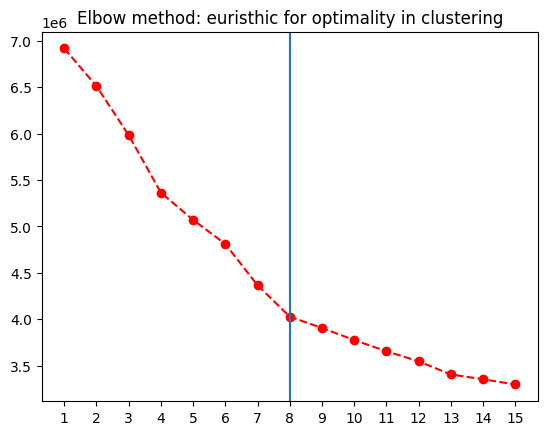

In [15]:
xs = list(distortions.keys())
ys = list(distortions.values())

plt.plot(xs,ys,'ro', linestyle='dashed')
plt.axvline(x = 8)
plt.xticks(xs)
plt.title('Elbow method: euristhic for optimality in clustering')

As we can see the behaviour of the euristhic is almost regular in the chosen range for k. With respect to choices we made to tune the parameters, we can consider the idea that making the algorithm running for more iterations would have provided us a better shaped curve. In the case we are now considering, the most likely elbow point is the one corresponding to $k=8$.

##### *Silhouette method*

We can use silhouette to evaluate different likley results.

In [ ]:


silhouette_scores = {}
semilla = 121233
for i in range(1,15):
    model = Cluster(dim=7, k=i, epsilon=0.1, max_run=30, seed = semilla)
    sil = model.silhouette(data)
    silhouette_scores[i] = sum(list(sil.values()))/len(list(sil.values()))

##### *Comparison with scikit-learn k-means++*



Let's use the dataset we obtained after the PCA:

In [2]:
data = pd.read_csv('projected_data.csv')

In [105]:
data

,CustomerID,0,1,2,3,4,5,6
0,C1010011,-2.155284,0.769231,-1.189896,0.716186,1.745473,-0.541324,-1.235996
1,C1010012,0.445059,-0.064466,-0.637879,0.141632,-0.524193,-0.244923,-0.265704
2,C1010014,-2.227886,-1.471651,-3.245768,-0.036780,-1.767338,-0.538044,-1.215998
3,C1010018,0.450198,0.567593,0.297071,0.234391,0.120684,0.718028,0.434944
4,C1010024,0.424123,0.233544,0.049774,0.025525,-0.081511,-0.835705,0.453655
...,...,...,...,...,...,...,...,...
839076,C9099836,0.409660,0.310703,-0.210136,-0.173010,-1.165089,0.146822,-0.183657
839077,C9099877,0.423432,-0.197570,1.234518,0.124302,-0.619169,0.063647,-0.331362
839078,C9099919,0.444576,0.484345,0.097468,0.101022,-0.303486,0.771472,0.474309
839079,C9099941,0.434072,0.067364,1.087769,0.086990,0.386533,-0.104067,-0.457665


In [3]:
relevant_df = data.drop(columns='CustomerID')

Let's standardize our dataset. Standardization prevents variables with larger scales from dominating how clusters are defined.\
It allows all variables to be considered by the algorithm with equal importance.

In [4]:
relevant_df = StandardScaler().fit_transform(relevant_df)
feat_cols = ['feature'+str(i) for i in range(1,8)]
relevant_df = pd.DataFrame(relevant_df,columns=feat_cols)

In [108]:
relevant_df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,-2.117863,0.702667,-1.157617,0.729602,1.746538,-0.430960,-1.025258
1,0.437332,-0.058888,-0.620575,0.144285,-0.524512,-0.194989,-0.220401
2,-2.189205,-1.344304,-3.157718,-0.037469,-1.768416,-0.428350,-1.008670
3,0.442382,0.518477,0.289012,0.238782,0.120758,0.571639,0.360786
4,0.416759,0.213335,0.048424,0.026003,-0.081561,-0.665324,0.376307
...,...,...,...,...,...,...,...
839076,0.402547,0.283816,-0.204436,-0.176251,-1.165800,0.116888,-0.152343
839077,0.416080,-0.180473,1.201029,0.126630,-0.619547,0.050671,-0.274865
839078,0.436858,0.442433,0.094824,0.102914,-0.303671,0.614186,0.393439
839079,0.426535,0.061535,1.058260,0.088619,0.386769,-0.082850,-0.379633


To obtain the optimal number of clusters into which to divide our dataset we sample and use KElbowVisualizer from yellowbrick.cluster.\
If the line chart looks like an arm, then the elbow (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.\
In the following, the KElbowVisualizer fits the model for a range of K values from 3 to 50, which is set by the parameter k=(3,50).\
When the model is fit with 14 clusters we can see an "elbow" in the graph.

In [5]:
relevant_df_sample = relevant_df.sample(20000)

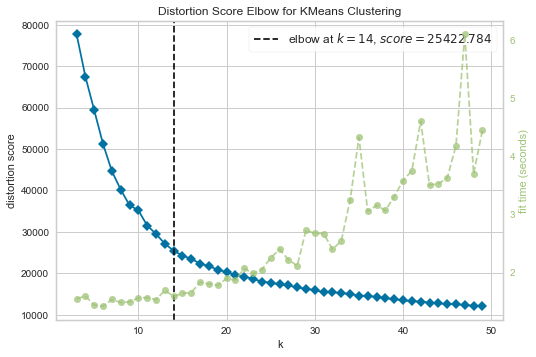

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(3,50))
visualizer.fit(relevant_df_sample)     
visualizer.show()  

We have now applied the elbow method using the already implemented version of kmeans++(from the scikit-learn library). \
We can see that although the optimal clustering number is almost the same, the distortion score is much lower.\
This may be due to the fact that in our case we have chosen a very low maximum iteration value for kmeans (mainly due to slow computation),\
but also because kmeans++ obviously performs better. K-means starts with allocating cluster centers randomly and then looks for "better" solutions.\
 K-means++ starts with allocation one cluster center randomly and then searches for other centers given the first one. \
So both algorithms use random initialization as a starting point, so can give different results on different runs. \
But since KMeans++ centers are distributed over the data it is more likely to have less cost(within cluster sum of square) then Kmeans.

In [111]:
model = KMeans(n_clusters=14,init='k-means++')

Let's plot our data to have a visual idea, just considering the first 3 principal components.

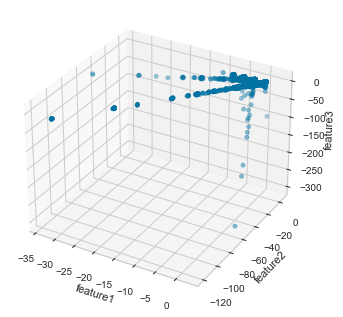

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = relevant_df['feature1']
y = relevant_df['feature2']
z = relevant_df['feature3']

# Plot the values
ax.scatter(x, y, z, c = 'b', marker='o')
ax.set_xlabel('feature1')
ax.set_ylabel('feature2')
ax.set_zlabel('feature3')

plt.show()

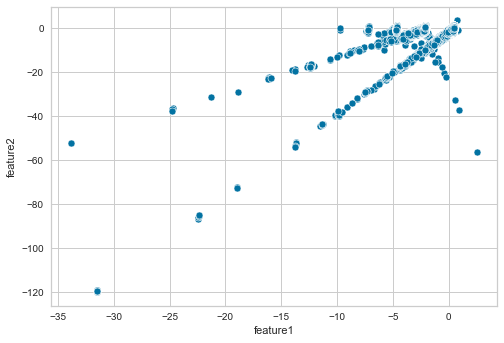

In [113]:
sns.scatterplot(x=relevant_df['feature1'],y=relevant_df['feature2'])
plt.show()

Time for Clustering

In [114]:
relevant_df['cluster'] = model.fit_predict(relevant_df)

In [116]:
relevant_df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,cluster
0,-2.117863,0.702667,-1.157617,0.729602,1.746538,-0.430960,-1.025258,6
1,0.437332,-0.058888,-0.620575,0.144285,-0.524512,-0.194989,-0.220401,7
2,-2.189205,-1.344304,-3.157718,-0.037469,-1.768416,-0.428350,-1.008670,2
3,0.442382,0.518477,0.289012,0.238782,0.120758,0.571639,0.360786,1
4,0.416759,0.213335,0.048424,0.026003,-0.081561,-0.665324,0.376307,1
...,...,...,...,...,...,...,...,...
839076,0.402547,0.283816,-0.204436,-0.176251,-1.165800,0.116888,-0.152343,7
839077,0.416080,-0.180473,1.201029,0.126630,-0.619547,0.050671,-0.274865,0
839078,0.436858,0.442433,0.094824,0.102914,-0.303671,0.614186,0.393439,1
839079,0.426535,0.061535,1.058260,0.088619,0.386769,-0.082850,-0.379633,0


<AxesSubplot:xlabel='feature1', ylabel='feature2'>

c:\Users\Angelo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


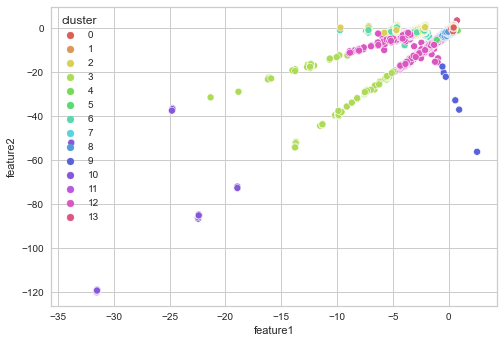

In [117]:
unique_values = len(relevant_df.cluster.unique())

sns.scatterplot(x=relevant_df['feature1'], 
                y=relevant_df['feature2'],
                palette=sns.color_palette('hls', unique_values),
               hue=relevant_df.cluster)

Let's visualize now the clustering in 3d, considering the first 3 principal components.

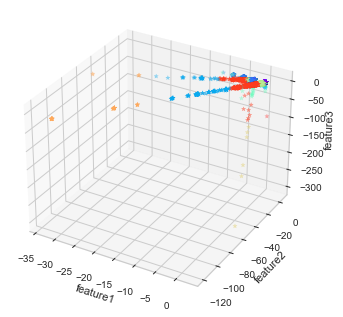

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(relevant_df.cluster.unique())))
relevant_df['c'] = relevant_df.cluster.map({i:colors[i] for i in range(0,14)})

x = relevant_df['feature1']
y = relevant_df['feature2']
z = relevant_df['feature3']

# Plot the values
ax.scatter(x, y, z, c = relevant_df.c, marker='*')
ax.set_xlabel('feature1')
ax.set_ylabel('feature2')
ax.set_zlabel('feature3')

plt.show()

Let's plot the centroids in 3d

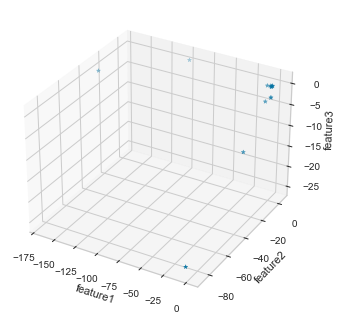

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = model.cluster_centers_[:,2]
y = model.cluster_centers_[:,1]
z = model.cluster_centers_[:,0]

# Plot the values
ax.scatter(x, y, z, c = 'b', marker='*')
ax.set_xlabel('feature1')
ax.set_ylabel('feature2')
ax.set_zlabel('feature3')

plt.show()

In [121]:
relevant_df.drop(columns='c',inplace=True)

In [122]:
relevant_df.to_pickle('relevant_df_pca.pkl')

In [20]:
relevant_df = pd.read_pickle('relevant_df_pca.pkl')

In [123]:
#to have an idea how big is every cluster
relevant_df.groupby('cluster').count()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7
cluster,,,,,,,
0,180491,180491,180491,180491,180491,180491,180491
1,275750,275750,275750,275750,275750,275750,275750
2,106989,106989,106989,106989,106989,106989,106989
3,154,154,154,154,154,154,154
4,30,30,30,30,30,30,30
5,3637,3637,3637,3637,3637,3637,3637
6,20128,20128,20128,20128,20128,20128,20128
7,79468,79468,79468,79468,79468,79468,79468
8,116988,116988,116988,116988,116988,116988,116988


Now we can add the cluster column created to the starting dataset, since the starting dataset is not standardized.

In [125]:
df = pd.read_pickle('customer_engineered.pkl')
df['cluster']=relevant_df['cluster']
df

,CustomerID,Number of transactions,Number of high volume transactions,AVG Transaction,AVG Balance,AVG Utilization,Most common gender,Most frequent location,CustomerAge,MAX Transaction,...,Max Utilization,Min Utilization,Last transaction,First transaction,Mean time between transactions,Balance traction,Number of higher volume transactions,Favourite Hour,Female outgo,cluster
0,C1010011,2,2.0,30.636,916.08762,885.45162,F,NEW DELHI,30,57.000,...,1437.89448,333.00876,2016-09-26,2016-09-08,18 days,2.697780,1.0,1,0.930278,6
1,C1010012,1,1.0,17.988,290.45388,272.46588,M,MUMBAI,28,17.988,...,272.46588,272.46588,2016-08-14,2016-08-14,0 days,0.000000,0.0,20,0.803869,7
2,C1010014,2,2.0,8.730,1201.35540,1192.62540,F,MUMBAI,31,14.460,...,1939.18512,446.06568,2016-07-08,2016-01-08,182 days,3.217322,1.0,15,0.020619,2
3,C1010018,1,0.0,0.360,5.95416,5.59416,F,CHAMPARAN,33,0.360,...,5.59416,5.59416,2016-09-15,2016-09-15,0 days,0.000000,0.0,17,18.566667,1
4,C1010024,1,1.0,60.000,1044.70380,984.70380,M,KOLKATA,57,60.000,...,984.70380,984.70380,2016-08-18,2016-08-18,0 days,0.000000,1.0,14,0.020000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.292,1596.80676,1588.51476,M,BHIWANDI,32,8.292,...,1588.51476,1588.51476,2016-07-08,2016-07-08,0 days,0.000000,1.0,0,0.000000,7
839077,C9099877,1,1.0,2.664,1152.76152,1150.09752,M,BANGALORE,26,2.664,...,1150.09752,1150.09752,2016-09-15,2016-09-15,0 days,0.000000,1.0,12,0.000000,0
839078,C9099919,1,0.0,1.512,66.71700,65.20500,M,GUNTUR,29,1.512,...,65.20500,65.20500,2016-08-18,2016-08-18,0 days,0.000000,0.0,12,0.000000,1
839079,C9099941,1,1.0,0.600,423.55104,422.95104,M,CHENNAI,28,0.600,...,422.95104,422.95104,2016-08-28,2016-08-28,0 days,0.000000,0.0,21,0.000000,0


## 2.4 Analysing your results!
You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:
* Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.
* Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.
* With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.
* Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Gender variable:
* Interpret the results for each pivot table.

The 3 variables we have chosen that are relevant for us are 'CustomerAge', 'AVG Balance' and 'Most common gender'.

As requested we categorize every variable in 4 categories.\
We have slittled 'CustomerAge' into 4 categories:
* Young: customer with an age between 0 and 30
* Adult: customer with an age between 30 and 50
* Old: customer with an age between 50 and 75
* Reired: customer with an age between 75 and the maximum value


In [126]:
df['Age_Category'] = pd.cut(df['CustomerAge'],bins=[-1,30,50,75,123],labels=['Young','Adult','Old','Retired'])
table = df.pivot_table(index='cluster',columns = 'Age_Category',aggfunc='count',fill_value=0)['CustomerAge']
round(table.div(table.sum(axis=1), axis=0)*100,2)

Age_Category,Young,Adult,Old,Retired
cluster,,,,
0,16.95,75.78,6.91,0.36
1,19.56,73.48,6.56,0.40
2,17.75,74.53,7.27,0.46
3,2.60,37.66,59.09,0.65
4,3.33,60.00,36.67,0.00
5,7.48,66.32,24.25,1.95
6,14.92,75.80,8.55,0.72
7,15.68,76.01,7.73,0.58
8,15.34,74.81,9.33,0.52


As we can see the clustering made a decent partition of the variable 'CustomerAge'. \
This tells us that the algorithm had an acceptable capability to create a partition between objects that have similar characteristics,\
and thus minimise the distance correctly.All the other clusters always contain more of one category than the others.\
For example, through this partition one might be able to generate category-specific bank offers.

We have slittled 'AVG Balance' into 4 categories:
* Basic: customer with an average balance between 0 and 1000
* Platinum	: customer with an average balance between 1000 and 10000
* Silver: customer with an average balance between 10000 and 100000
* Gold: customer with an average balance between 100000 and the maximum value

In [127]:
df['Balance_type'] = pd.cut(df['AVG Balance'],bins=[-1,1000,10000,100000,1380426],labels=['Basic','Platinum','Silver','Gold'])
table = df.pivot_table(index='cluster',columns = 'Balance_type',aggfunc='count',fill_value=0)['AVG Balance']
round(table.div(table.sum(axis=1), axis=0)*100,2)

Balance_type,Basic,Platinum,Silver,Gold
cluster,,,,
0,84.92,15.03,0.05,0.00
1,87.29,12.66,0.05,0.00
2,78.10,20.80,1.10,0.00
3,0.00,0.00,0.00,100.00
4,43.33,40.00,16.67,0.00
5,50.21,38.96,10.59,0.25
6,71.63,26.23,2.14,0.00
7,78.74,20.04,1.21,0.00
8,70.39,21.48,8.13,0.00


As we can see the clustering make a good partition of the variable 'AVG Balance'. The cluster 3, 10 and 13 contain transactions relating only to a certain category.\
This tells us that the algorithm was able to create a partition between objects that have similar characteristics, and thus minimise the distance correctly\
Also the other clusters always contain more of one category than the others, which means that even here you can get a good partition.

We have slittled 'Gender_Cust' into 2 categories just considering 'Most common gender':
* Female
* Male

In [128]:
df['Gender_Cust']=np.where(df['Most common gender']=='F',1,0)
table = df.pivot_table(index='cluster',columns = 'Most common gender',aggfunc='count',fill_value=0)['Gender_Cust']
round(table.div(table.sum(axis=1), axis=0)*100,2)


Most common gender,F,M
cluster,,
0,28.15,71.85
1,26.36,73.64
2,44.50,55.50
3,17.53,82.47
4,30.00,70.00
5,29.89,70.11
6,44.46,55.54
7,29.58,70.42
8,27.41,72.59


We can say exactly the same comment above.

### 6.
Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

c:\Users\Angelo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


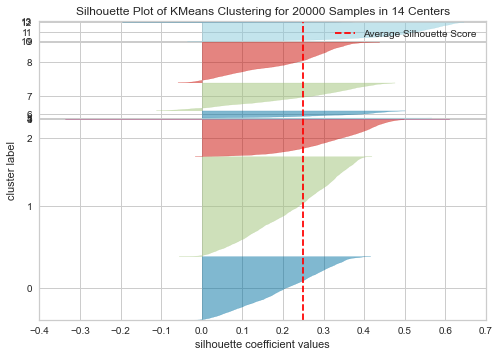

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 20000 Samples in 14 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [131]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
relevant_df_sample = relevant_df.sample(20000)
visualizer.fit(relevant_df_sample)        # Fit the data to the visualizer
visualizer.show()       

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). \
The value of the silhouette ranges between [1, -1], where a high value indicates that the object is well matched to its own cluster and\
poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate.\
Silhouette is a measure of how a clustering algorithm has performed. After computing the silhouette coefficient of each point in the dataset,\
plot it to get a visual representation of how well the dataset is clustered into k clusters. The silhouette plot displays a measure of how\
close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like the number\
of clusters visually. This measure has a range of [-1, 1].\
Since in this case the silhouette coefficient value is 0.25 approximately we can say that a reasonable structure has been found.